# 2. Running Inference on the GenAI Models
This Notebook is used to run inference on the 2 models hosted to SageMaker Endpoints. The first model is Segment Anything Model (SAM) and the second model is the InPainting model.

## 2.1 Install Dependencies and Import Libraries
Here we are using `SageMaker, Numpy, Pillow` libraries for Python

In [2]:
# Import libraries
import numpy as np, matplotlib.pyplot as plt
from PIL import Image
from sagemaker.pytorch import PyTorchPredictor
from sagemaker.serializers import JSONSerializer
from sagemaker.deserializers import JSONDeserializer

## 2.2 Model 1: SAM

### Run inference on the SAM Model
In this section, we will demonstrate the inference on the SAM model. 
The product image is provided as an input to the model and the product mask is genereted as an output. 

SAM Endpoint Name: sam-pytorch-2023-05-31-22-12-32-094654


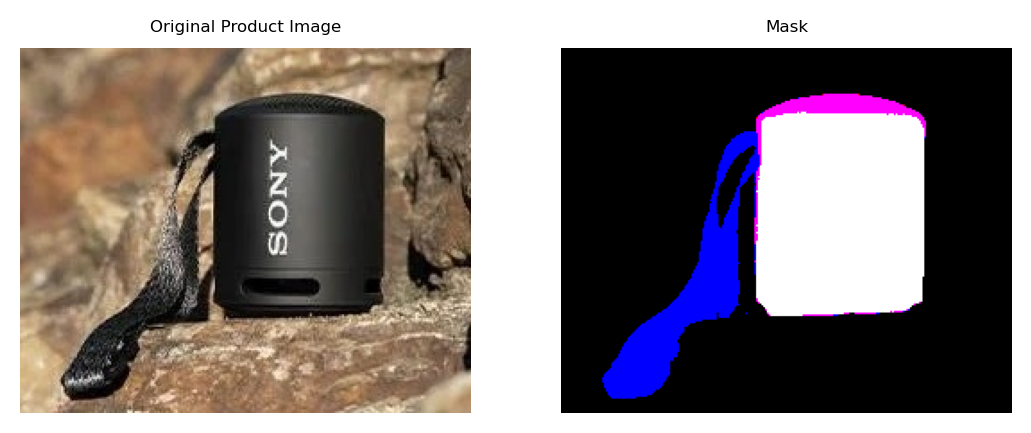

In [22]:
%store -r SAM_ENDPOINT_NAME
print(f'SAM Endpoint Name: {SAM_ENDPOINT_NAME}')

raw_image = Image.open("images/speaker.png").convert("RGB")

predictor_sam = PyTorchPredictor(endpoint_name=SAM_ENDPOINT_NAME,
                             deserializer=JSONDeserializer())

output_array = predictor_sam.predict(raw_image, initial_args={'Accept': 'application/json'})

mask_image = Image.fromarray(np.array(output_array).astype(np.uint8))

# save the image using PIL Image
mask_image.save('images/speaker_mask.png')

# We are going to plot the outputs
plot_images = [raw_image, mask_image]
titles = ['Original Product Image', 'Mask']
fig, ax = plt.subplots(1,len(plot_images), dpi = 200)
for k1, img in enumerate(plot_images):
    ax[k1].imshow(img); ax[k1].axis('off')
    ax[k1].set_title(titles[k1], fontsize=6)

## 2.3 Model 2: InPainting

### Run inference on the InPainting Model
In this section, we will demonstrate the inference on the InPainting model.
The product image, the previously generated mask, foreground promts, background prompts and negative prompts are used as an input to generate the right type of image. 

InPainting Endpoint Name: inpainting-pytorch-2023-05-31-22-19-35-804898


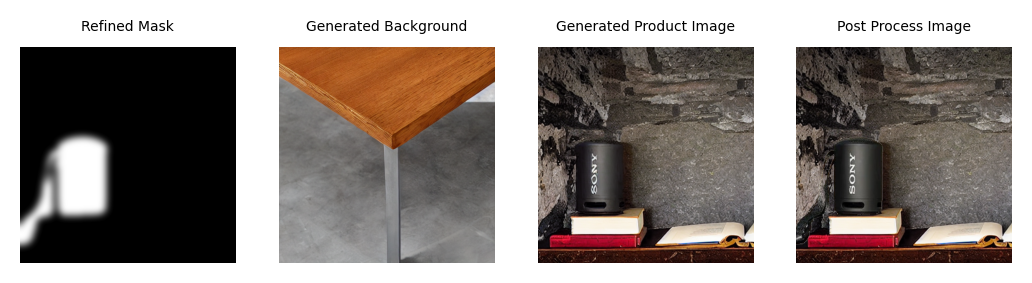

In [24]:
%store -r INPAINTING_ENDPOINT_NAME
print(f'InPainting Endpoint Name: {INPAINTING_ENDPOINT_NAME}')

raw_image = Image.open("images/speaker.png").convert("RGB")
mask_image = Image.open('images/speaker_mask.png').convert('RGB')
prompt_fr = "apple, books"
prompt_bg = "table"
negative_prompt = "longbody, lowres, bad anatomy, bad hands, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, letters" 

inputs = {}
inputs["image"] = np.array(raw_image)
inputs["mask"] = np.array(mask_image)
inputs["prompt_fr"] = prompt_fr
inputs["prompt_bg"] = prompt_bg
inputs["negative_prompt"] = negative_prompt

predictor_inpainting = PyTorchPredictor(endpoint_name=INPAINTING_ENDPOINT_NAME,
                             serializer=JSONSerializer(),
                             deserializer=JSONDeserializer())

output_array = predictor_inpainting.predict(inputs, initial_args={'Accept': 'application/json'})

gai_mask = Image.fromarray(np.array(output_array[2]).astype(np.uint8))
gai_background = Image.fromarray(np.array(output_array[1]).astype(np.uint8))
gai_image = Image.fromarray(np.array(output_array[0]).astype(np.uint8))
post_image = Image.fromarray(np.array(output_array[3]).astype(np.uint8))

# We are going to plot the outputs
plot_images = [gai_mask, gai_background, gai_image, post_image]
titles = ['Refined Mask', 'Generated Background', 'Generated Product Image', 'Post Process Image']
fig, ax = plt.subplots(1,len(plot_images), dpi = 200)
for k1, img in enumerate(plot_images):
    ax[k1].imshow(img); ax[k1].axis('off')
    ax[k1].set_title(titles[k1], fontsize=5)


# save the generated image using PIL Image
post_image.save('images/speaker_generated.png')